In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./data/training_dataset.csv",low_memory=False)
df.match_date = df.match_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [2]:
df

,player1_name,player1_atprank,player2_name,player2_atprank,match_date,match_location,match_tournament,match_surface,match_odd_player1,match_odd_player2,winner_player1
0,Harrison R.,433.0,Mager G.,91.0,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.72,2.00,0
1,Kwon S.W.,82.0,Korda S.,213.0,2021-01-07,Delray Beach,Delray Beach Open,Hard,2.00,1.72,0
2,Paul T.,55.0,Nam J.S.,NaN,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.12,6.00,1
3,Travaglia S.,74.0,Kecmanovic M.,42.0,2021-01-07,Antalya,Antalya Open,Hard,2.62,1.44,1
4,Monteiro T.,84.0,Bellucci T.,278.0,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.36,3.00,1
...,...,...,...,...,...,...,...,...,...,...,...
7057,Tiafoe F.,64.0,Evans D.,31.0,2023-08-05,Washington,Citi Open,Hard,1.29,3.75,0
7058,Griekspoor T.,172.0,Fritz T.,29.0,2023-08-06,Washington,Citi Open,Hard,3.50,1.30,1
7059,Tsitsipas S.,6.0,De Minaur A.,25.0,2023-08-06,Los Cabos,Los Cabos Open,Hard,1.36,3.20,1
7060,Evans D.,31.0,Dimitrov G.,20.0,2023-08-06,Washington,Citi Open,Hard,3.20,1.36,1


In [13]:
df = df.dropna()

In [21]:
from sklearn.model_selection import train_test_split

X = df.drop(["player1_name", "player2_name","match_location", "match_tournament", "match_surface", "winner_player1"],axis=1)
y = df.winner_player1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [32]:
from sklearn import preprocessing

X_train_filtered = X_train.drop("match_date",axis=1)
X_test_filtered = X_test.drop("match_date",axis=1)

#scaler = preprocessing.StandardScaler().fit(X_train_filtered)
#X_train_filtered = scaler.transform(X_train_filtered)
#X_test_filtered = scaler.transform(X_test_filtered)

X_train_filtered

,player1_atprank,player2_atprank,match_odd_player1,match_odd_player2
0,433.0,91.0,1.72,2.00
1,82.0,213.0,2.00,1.72
3,74.0,42.0,2.62,1.44
4,84.0,278.0,1.36,3.00
5,49.0,82.0,1.61,2.20
...,...,...,...,...
5373,71.0,35.0,2.38,1.57
5374,331.0,55.0,3.75,1.29
5376,141.0,310.0,1.40,3.00
5377,78.0,166.0,2.00,1.80


In [47]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
model = model.fit(X_train_filtered, y_train)

#cross_val_score(dtree, X_test, y_test, cv=10)

y_predict = model.predict(X_test_filtered)

accuracy_score(y_predict, y_test)

0.6649616368286445

In [25]:
# ROI return of investment on all games

print("We bet 1€ on all test matches")
df_roi = X_test.copy()
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

money_invested=df_roi.shape[0]
print("money spent:", money_invested,"€")

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won,2) - money_invested,"€")

We bet 1€ on all test matches
money spent: 1173 €
money won: 1102.47 €
TOTAL: -70.52999999999997 €


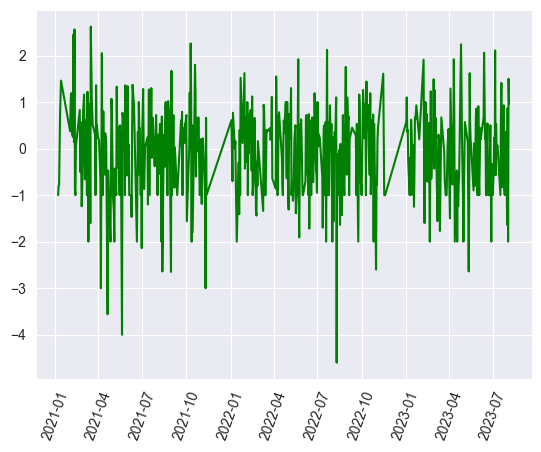

In [20]:
# on all games 
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [57]:
#only games where predict proba is > 0.8

y_predict_proba = model.predict_proba(X_test_filtered)


print("We bet 1€ on all test matches where proba score is > 0.9")
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

df_roi= df_roi.loc[(df_roi["y_predict_proba"]>0.9) | (df_roi["y_predict_proba"]<0.1)]

money_invested=df_roi.shape[0]
print("money spent:", money_invested,"€")

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won,2) - money_invested,"€")
                

We bet 1€ on all test matches where proba score is > 0.9
money spent: 89 €
money won: 89.48 €
TOTAL: 0.480000000000004 €


C:\Users\chbou\AppData\Local\Temp\ipykernel_14624\2501785873.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():
